# Import Packages

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gseapy
import os

## Read data into scanpy
* needs to be transposed first to be loaded properly
* load into scanpy object

In [26]:
def transpose_csv(csv_path, output_csv_path='transposed.csv', delimiter=','):
    # code copied from: https://stackoverflow.com/questions/7156539/how-do-i-transpose-pivot-a-csv-file-with-python-without-loading-the-whole-file
    import csv
    
    print("easter egg")

    transposed_iterator = zip(*csv.reader(open(csv_path)))
    with open(output_csv_path, 'w') as out:
        for row in transposed_iterator:
            out.write(delimiter.join(row) + '\n')

raw_file = "../GSE125881_raw.expMatrix.csv" # read in the file here, ../ means folder above
transposed_file = "expMatrix_transposed.csv" #we needed to transpose the axes of the file
figpath = '../figures' #ATB, I am trying to save figures as I go?

if not os.path.exists(transposed_file):
    transpose_csv(raw_file, transposed_file)

easter egg


In [27]:
# we see 62k cells and 20k genes
expr = sc.read_csv(transposed_file, first_column_names=True)
expr

AnnData object with n_obs × n_vars = 62167 × 20223

## Quality Control
* filter cells with < 200 genes
* filter genes with < 3 cells
* filter cells with > 10% mitochodrial genes

In [28]:
expr.var['mt'] = expr.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(expr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
expr.obs.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGCGTCTAT-1,2500,8780.0,333.0,3.792711
AAACCTGCAATAGAGT-1,2549,8782.0,739.0,8.414940
AAACCTGCATGACGGA-1,3146,10911.0,540.0,4.949134
AAACCTGGTAGTGAAT-1,4310,18042.0,1167.0,6.468241
AAACCTGGTCTCCCTA-1,4628,24558.0,1217.0,4.955615


In [29]:
#figure settings
sc.settings.set_figure_params(dpi_save = 60, dpi = 60)
sc.settings.figdir = figpath

In [30]:
# n_genes_by_counts: Number of genes expressed in each cell (we filter out those with < 200)
# pct_counts_mt: Percentage of reads in each cell that are mitochondrial
# also filter out cells with >10% mitochondrial reads
sc.pp.filter_cells(expr, min_genes=200)

In [31]:
sc.pp.filter_genes(expr, min_cells=3)

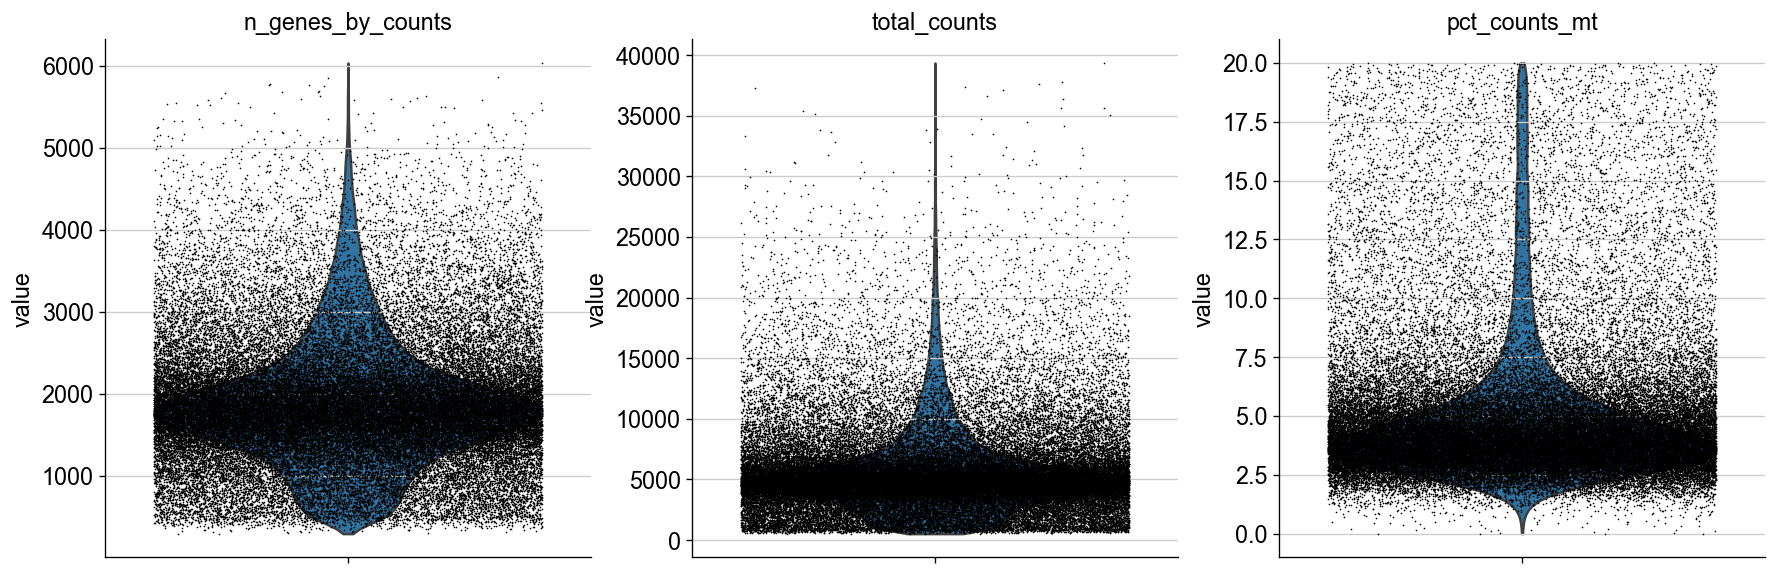

In [32]:
sc.pl.violin(expr, ['n_genes_by_counts', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [33]:
expr = expr[expr.obs.n_genes_by_counts > 200,]
expr = expr[expr.obs.pct_counts_mt < 10,]

## Normalization
* normalize data to log(CPM+1)
* look at highly variable genes
* scale normalize the data

In [34]:
sc.pp.normalize_total(expr)
sc.pp.log1p(expr)
expr.raw = expr 

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [35]:
# notice that most of the high variable genes are TRB genes
sc.pp.highly_variable_genes(expr)
expr.var['trb'] = expr.var_names.str.startswith('TRB')
expr.var.loc[expr.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,trb
S100A9,False,77,0.019689,99.876140,1224.0,77,True,0.013921,4.757143,14.140092,False
TRBV7-2,False,2294,0.481992,96.309939,29964.0,2294,True,0.377325,3.484430,8.916879,True
TRBV10-3,False,1090,0.326942,98.246658,20325.0,1090,True,0.281928,3.357422,8.565622,True
MTRNR2L12,False,58496,8.922001,5.905062,554654.0,58496,True,2.325795,3.318659,3.073340,False
LYZ,False,368,0.034472,99.408046,2143.0,368,True,0.022269,3.287997,9.632686,False
TRBV7-3,False,1243,0.280921,98.000547,17464.0,1243,True,0.243818,3.256322,8.286018,True
TRBV4-1,False,2035,0.489408,96.726559,30425.0,2035,True,0.405404,3.205354,8.145060,True
TRBV11-2,False,2305,0.617900,96.292245,38413.0,2305,True,0.462127,3.176631,8.065622,True
TRBV12-3,False,1589,0.389178,97.443982,24194.0,1589,True,0.329502,3.121294,7.912581,True
TRBV13,False,1036,0.254122,98.333521,15798.0,1036,True,0.204568,3.077064,8.985533,True


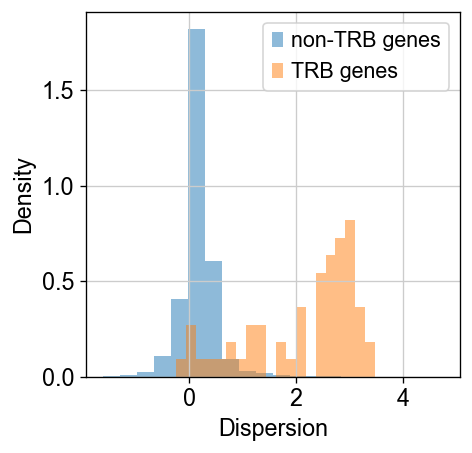

In [36]:
plt.hist(data=expr.var.loc[~expr.var.trb], x="dispersions", label="non-TRB genes", density=True, alpha=0.5, bins=20)
plt.hist(data=expr.var.loc[expr.var.trb], x="dispersions", label="TRB genes", density=True, alpha=0.5, bins=20)
plt.xlabel("Dispersion")
plt.ylabel("Density")
plt.legend()
plt.show()

In [37]:
sc.pp.scale(expr, max_value=10)

# Visualize clusters

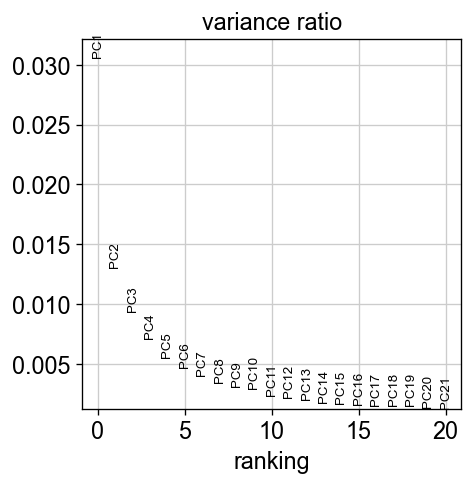

In [38]:
sc.tl.pca(expr)
sc.pl.pca_variance_ratio(expr, n_pcs=20)

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


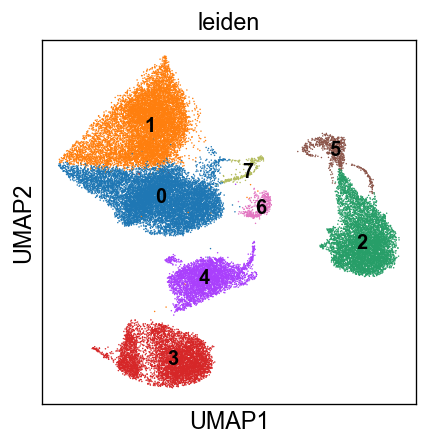

In [16]:
sc.pp.neighbors(expr, n_pcs=15)
sc.tl.leiden(expr, resolution=0.2)
sc.tl.umap(expr)
fig = sc.pl.umap(expr, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data')

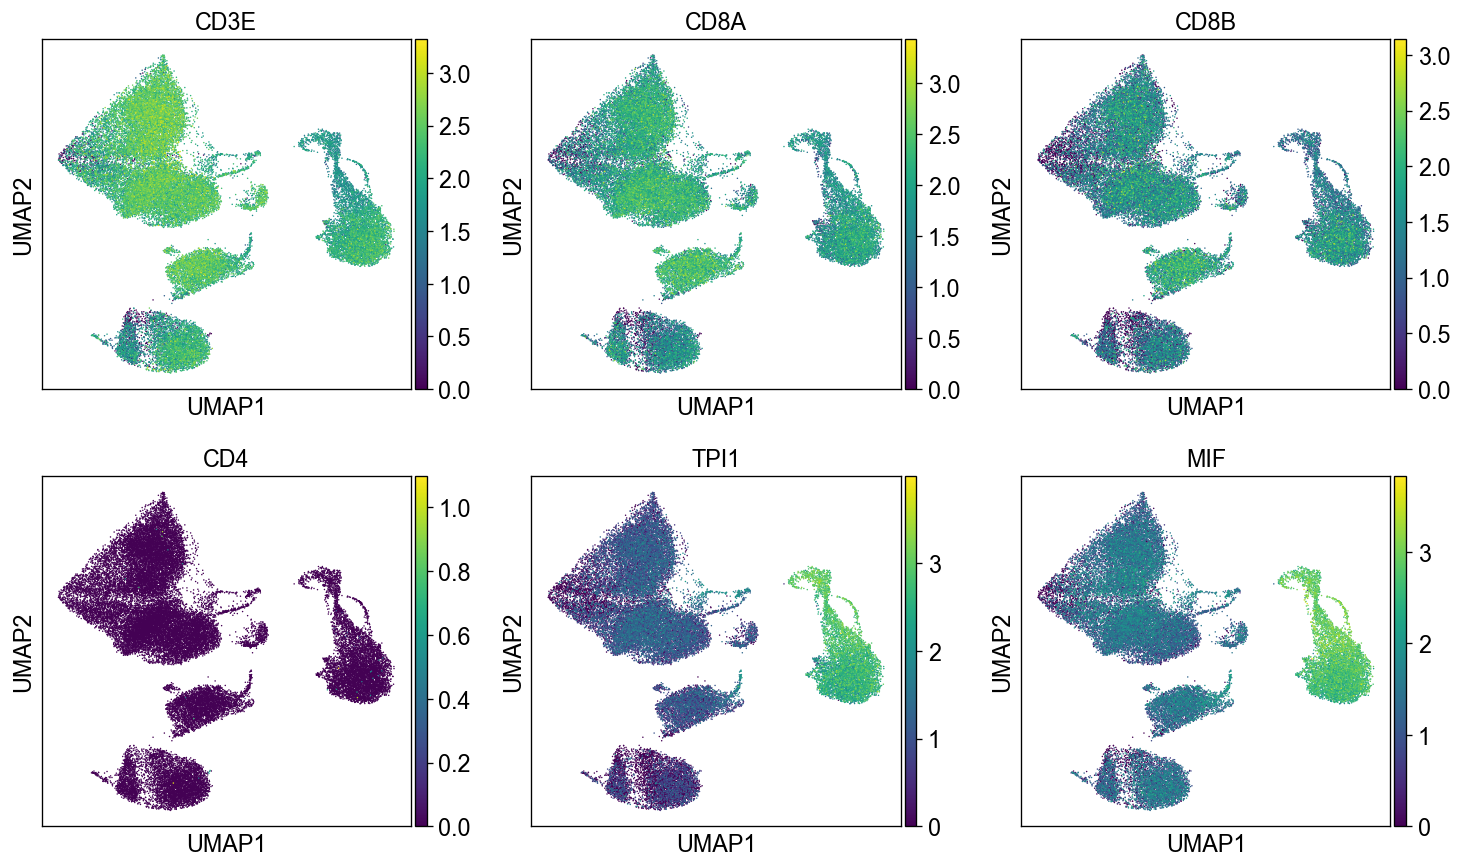

In [17]:
genes_to_plot = ["CD3E", "CD8A", "CD8B", "CD4", "TPI1", "MIF"] 
sc.pl.umap(expr, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3, cmap='viridis')

In [18]:
#sc.pl.violin(expr, genes_to_plot,
#             jitter=0.4, multi_panel=True)

In [19]:
#sc.pl.stacked_violin(expr, genes_to_plot, groupby='leiden', swap_axes=True)
#plt.show()

In [20]:
# Single cell heatmap of feature expression

print(os.getcwd())
gene_md = "../GSE125881_raw.expMatrix.csv"

/Users/andrewburden/Library/CloudStorage/OneDrive-Stanford/PycharmProjects/TCR_Seq_Project/CAR_T_clonal_kinetics


# Match barcode data with metadata and visualized based on sample info

In [21]:
meta = pd.read_csv("../geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))
meta.head(10)

#I couldnt get the new code to work so I manually edited the metadata

,gsm_name,id_in_expmatrix,patient_id,disease_state,time_point,time_point_type,ID,Assay,Age,Sex,CD8_T_cell_selection,LD,Cell_dose(EGFRt+cells/kg),Neurotox,CRS,Outcome,DFS/PFS_Status,DFS/PFS_Day
0,GSM3583861,1,CLL-1,CLL,IP,IP,CLL-1,10x,61,M,CD8,Cy/Flu,2x105,0,0,CR,CR_Ongoing,947
1,GSM3583862,2,CLL-1,CLL,d21,Early,CLL-1,10x,61,M,CD8,Cy/Flu,2x105,0,0,CR,CR_Ongoing,947
2,GSM3583863,3,CLL-1,CLL,d38,Contraction,CLL-1,10x,61,M,CD8,Cy/Flu,2x105,0,0,CR,CR_Ongoing,947
3,GSM3583864,4,CLL-1,CLL,d112,Late,CLL-1,10x,61,M,CD8,Cy/Flu,2x105,0,0,CR,CR_Ongoing,947
4,GSM3583865,8,CLL-2,CLL,IP,IP,CLL-2,10x,53,F,CD8,Cy/Flu,2x106,3,2,CR,CR_Ongoing,764
5,GSM3583866,9,CLL-2,CLL,d12,Early,CLL-2,10x,53,F,CD8,Cy/Flu,2x106,3,2,CR,CR_Ongoing,764
6,GSM3583867,10,CLL-2,CLL,d29,Contraction,CLL-2,10x,53,F,CD8,Cy/Flu,2x106,3,2,CR,CR_Ongoing,764
7,GSM3583868,11,CLL-2,CLL,d83,Late,CLL-2,10x,53,F,CD8,Cy/Flu,2x106,3,2,CR,CR_Ongoing,764
8,GSM3583869,16,NHL-6,NHL,IP,IP,NHL-6,10x-I,64,M,CD8TCM,Cy/Flu,2x106,3,4,CR,Progression,285
9,GSM3583870,5,NHL-6,NHL,d12,Early,NHL-6,10x-I,64,M,CD8TCM,Cy/Flu,2x106,3,4,CR,Progression,285


In [24]:
expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)
expr.obs["patient_timepoint"] = expr.obs["patient_id"] + "-" + expr.obs["time_point_type"]
#expr.obs["outcome"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["Outcome"])))
expr.obs["status"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["DFS/PFS_Status"])))


/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


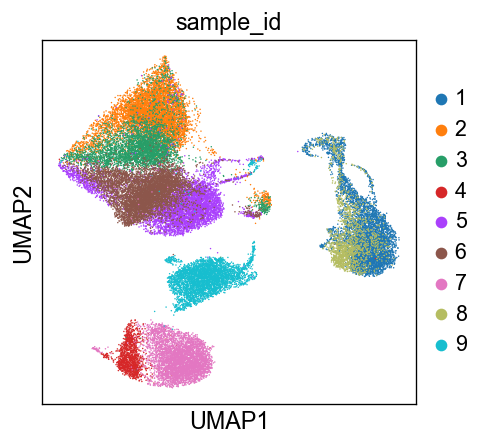

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


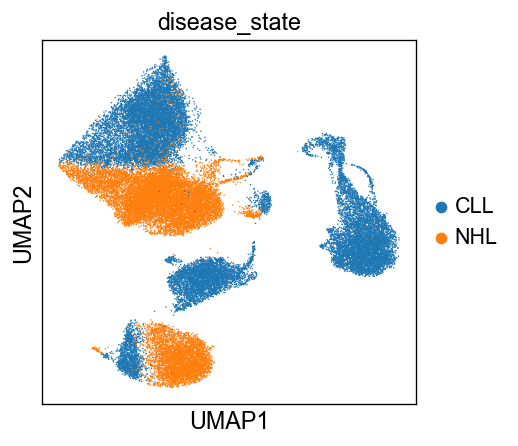

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


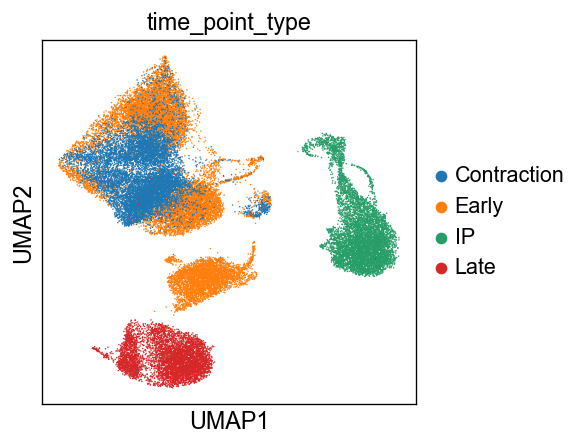

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


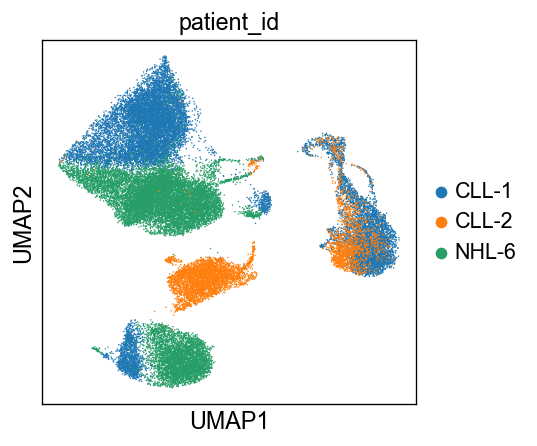

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


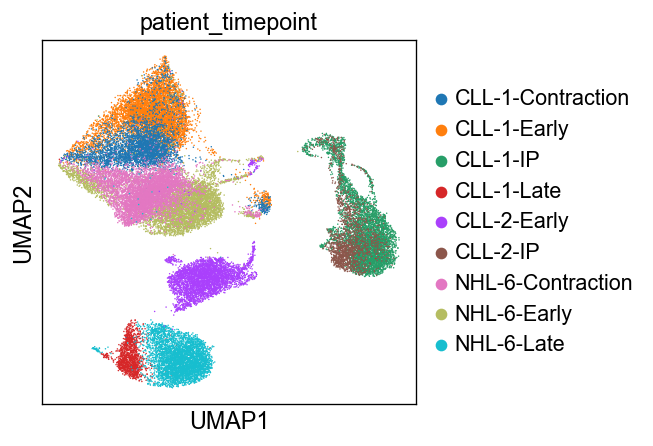

KeyError: 'outcome'

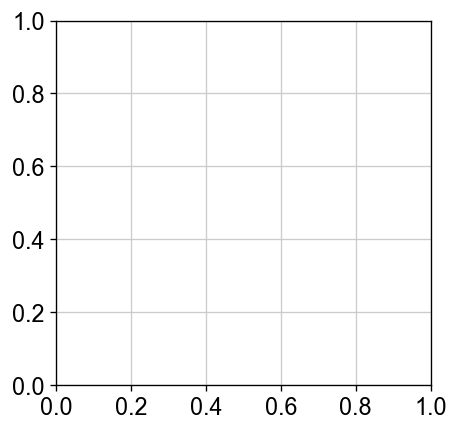

In [25]:
sc.pl.umap(expr, color="sample_id")
sc.pl.umap(expr, color="disease_state")
sc.pl.umap(expr, color="time_point_type")
sc.pl.umap(expr, color="patient_id")
sc.pl.umap(expr, color="patient_timepoint")
sc.pl.umap(expr, color="outcome")
sc.pl.umap(expr, color="status")

# Differential Expression (TODO)
* for a given patient how does gene expression change over time?
    * compare Early, Contraction, and Late to IP
    * do GSEA btwn E,C,L and IP

# T-test

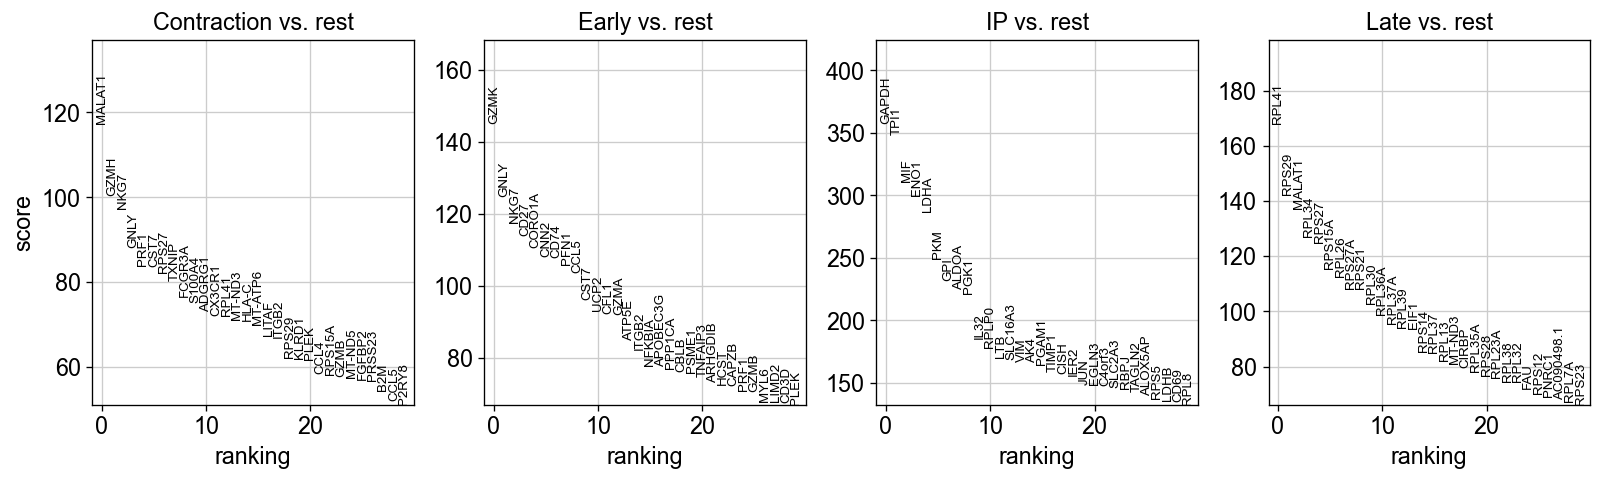

In [62]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test', key_added = 't-test')
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test')

In [63]:
#results are stored in the adata.uns['t-test'] slot
expr

AnnData object with n_obs × n_vars = 57122 × 20107
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'sample_id', 'disease_state', 'time_point_type', 'patient_id', 'patient_timepoint', 'status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'trb', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_id_colors', 'disease_state_colors', 'time_point_type_colors', 'patient_id_colors', 'patient_timepoint_colors', 't-test'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# T-test overestimated_variance

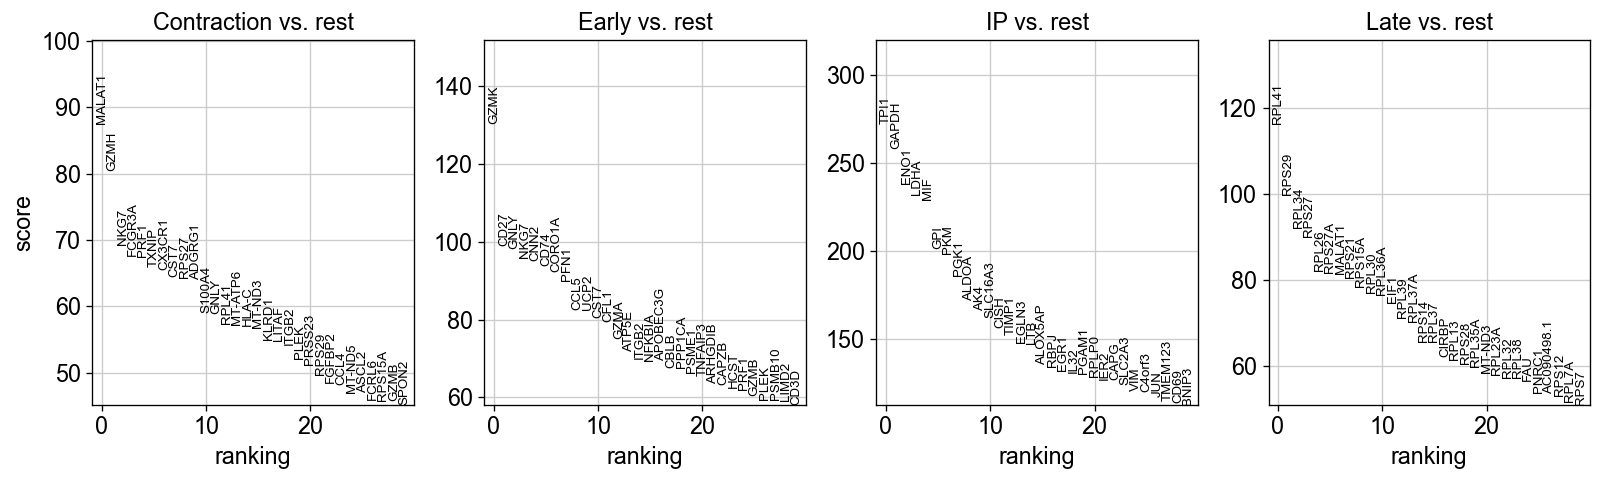

In [64]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test_overestim_var', key_added ="t-test_ov")
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test_ov')

# Wilcoxon rank-sum

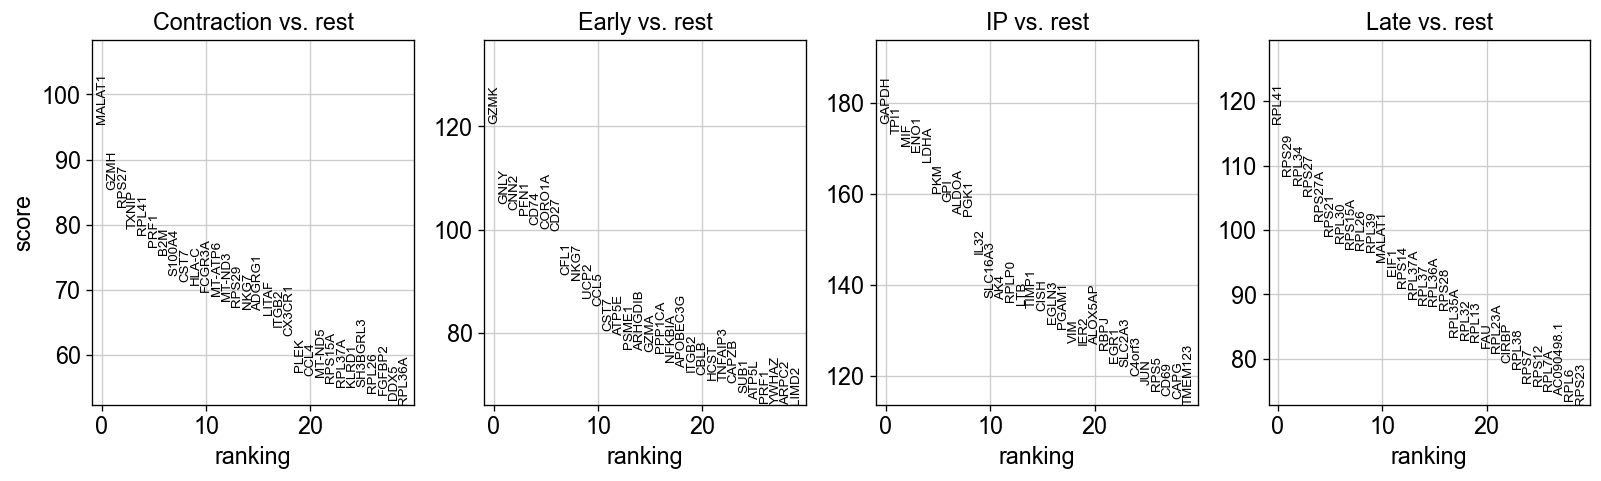

In [65]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 'wilcoxon', key_added = 'wilcoxon')
sc.pl.rank_genes_groups(expr, n_genes = 30, sharey=False, key = "wilcoxon")

# Logistic Regression Test

In [66]:
sc.tl.rank_genes_groups(expr, 'time_point_type', method = 'logreg', key_added = 'logreg')
sc.pl.genes_groups(expr, n_genes = 30, sharey=False, key = 'logreg')


KeyboardInterrupt



# Compare Genes

In [67]:
expr

AnnData object with n_obs × n_vars = 57122 × 20107
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'sample_id', 'disease_state', 'time_point_type', 'patient_id', 'patient_timepoint', 'status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'trb', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_id_colors', 'disease_state_colors', 'time_point_type_colors', 'patient_id_colors', 'patient_timepoint_colors', 't-test', 't-test_ov', 'wilcoxon', 'logreg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

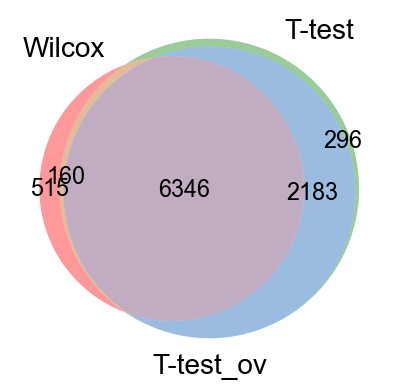

In [68]:
#compare culster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(expr, group='IP', key = 'wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox', 'T-test', 'T-test_ov'))
plt.show()

#KeyError: "None of [Index(['0'], dtype='object')] are in the [columns]"

# Visualization

In [69]:
expr.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,trb,mean,std
RP11-34P13.7,False,38,0.000611,99.938874,38.0,38,False,0.000619,0.430941,0.867103,False,0.000398,0.017694
FO538757.3,False,55,0.000885,99.911529,55.0,55,False,0.000644,-0.125891,-0.841283,False,0.000468,0.016660
FO538757.2,False,10715,0.209018,82.764167,12994.0,10715,False,0.171796,0.247772,0.305134,False,0.120980,0.283590
AP006222.2,False,469,0.007657,99.245580,476.0,469,False,0.006566,0.066244,-0.251805,False,0.004568,0.055311
RP4-669L17.10,False,77,0.001255,99.876140,78.0,77,False,0.001100,0.439406,0.893074,False,0.000705,0.023560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,False,989,0.016311,98.409124,1014.0,989,False,0.014320,0.181777,0.102656,False,0.009826,0.082005
AC007325.4,False,6,0.000097,99.990349,6.0,6,False,0.000038,-0.133470,-0.864534,False,0.000028,0.003937
AL354822.1,False,215,0.003491,99.654157,217.0,215,False,0.003037,0.424757,0.848131,False,0.001988,0.038440
AC004556.1,False,786,0.012820,98.735664,797.0,786,False,0.011323,0.353681,0.630065,False,0.007522,0.074090


/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


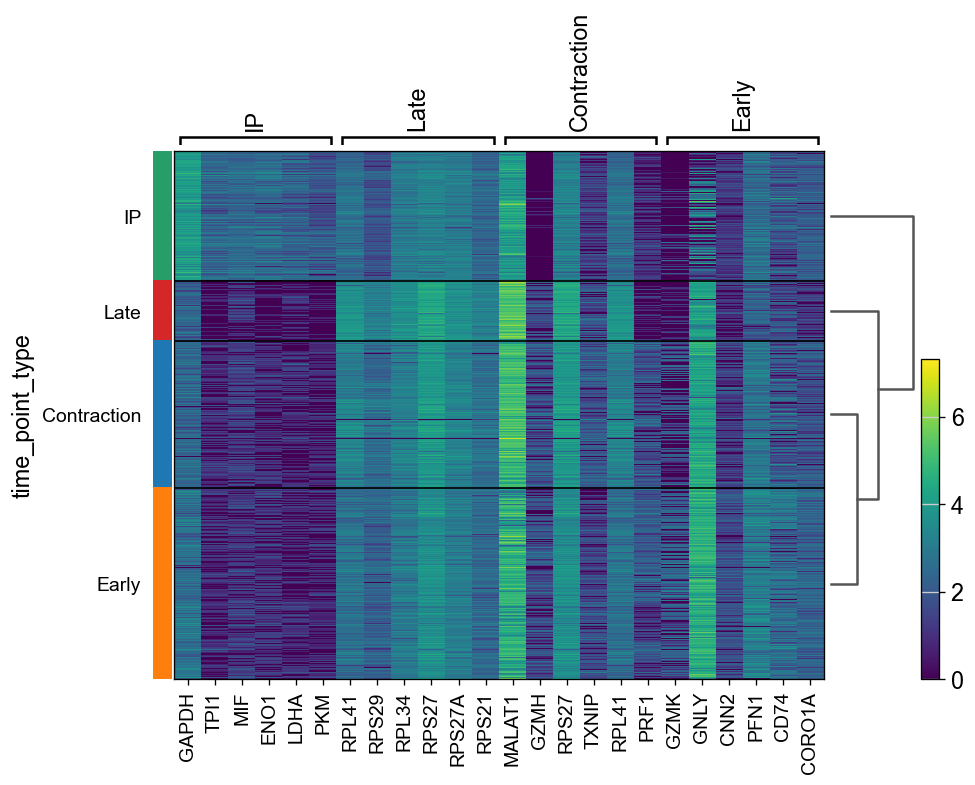

In [70]:
sc.pl.rank_genes_groups_heatmap(expr, n_genes = 6, key="wilcoxon", groupby="time_point_type", show_gene_labels=True)

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


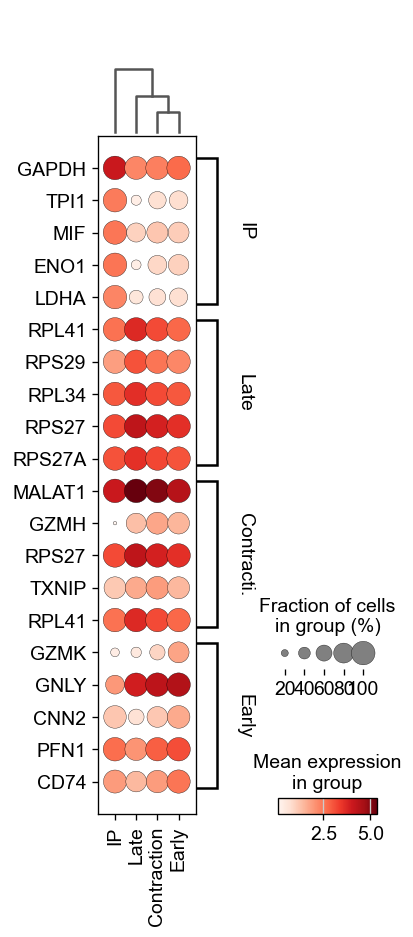

In [71]:
sc.pl.rank_genes_groups_dotplot(expr, n_genes=5, key='wilcoxon', groupby='time_point_type', swap_axes=True)

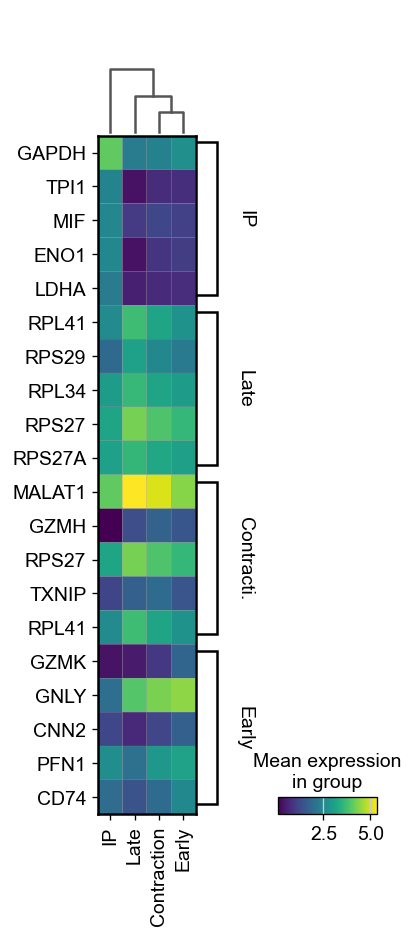

In [72]:
sc.pl.rank_genes_groups_matrixplot(expr, n_genes=5, key='wilcoxon', groupby="time_point_type", swap_axes=True)

# Compare Specific Clusters

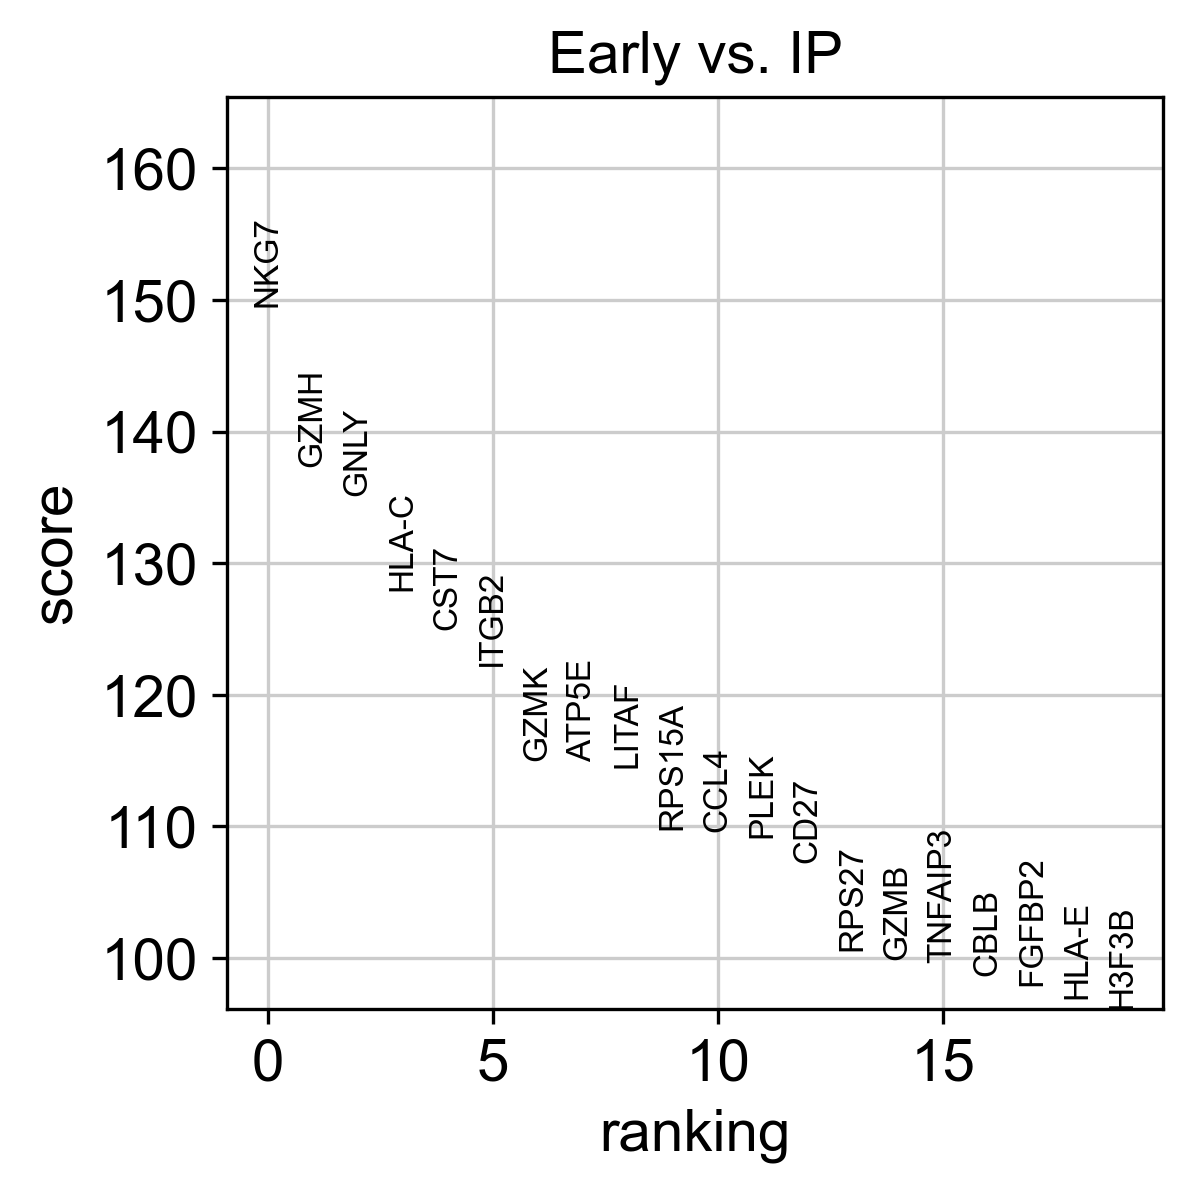

In [70]:
sc.tl.rank_genes_groups(expr, "time_point_type", groups=['Early'], reference = 'IP', method = 'wilcoxon')
sc.pl.rank_genes_groups(expr, groups=['Early'], n_genes=20)

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


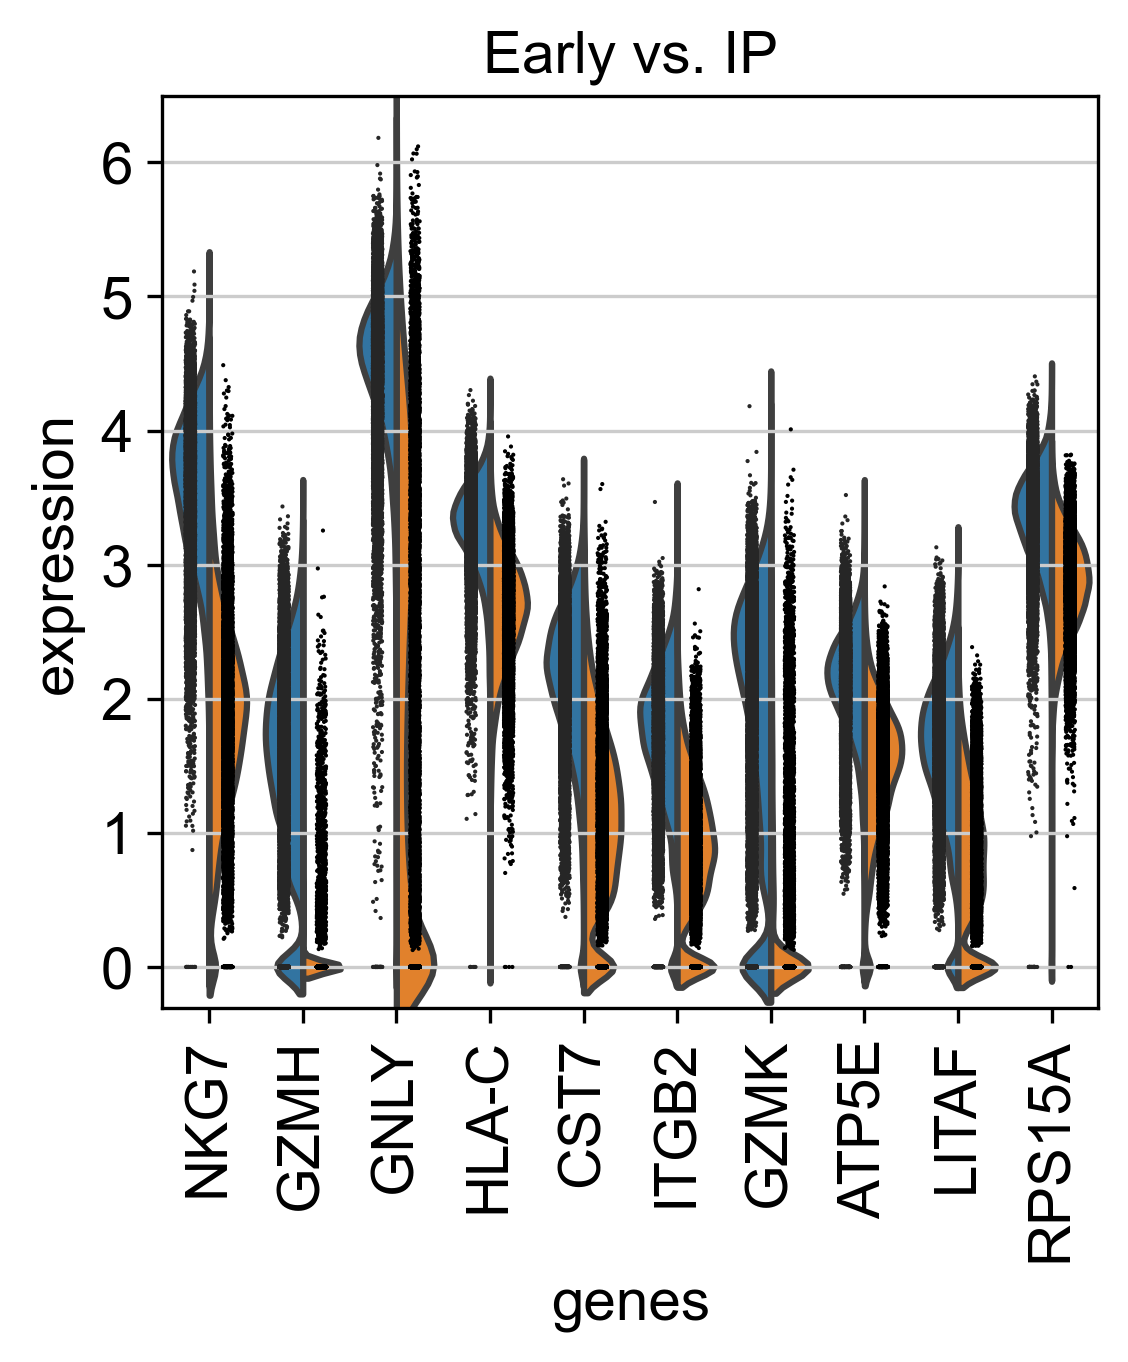

In [69]:
sc.pl.rank_genes_groups_violin(expr, groups='Early', n_genes = 10, jitter=True)

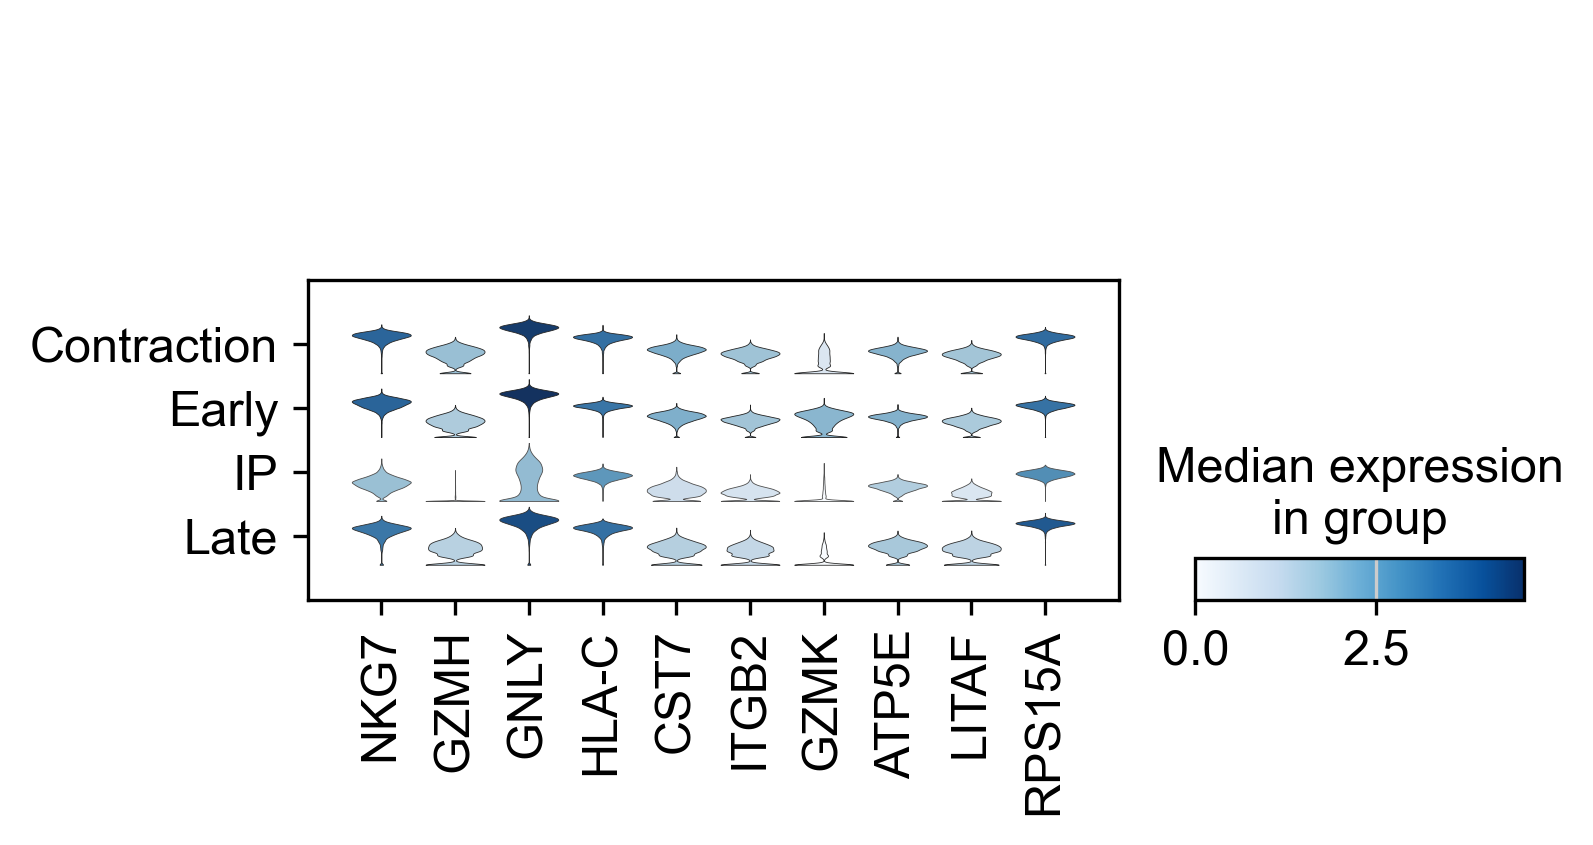

In [72]:
#plot the same genes as violins across all the datasets

#convert numpy.recarray to list
mynames = [x[0] for x in expr.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(expr, mynames, groupby = "time_point_type")

# Differential expression across conditions

In [89]:
cl1 = expr[expr.obs['time_point_type'] == '4',:]
cl1.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,trb,mean,std
RP11-34P13.7,False,38,0.000611,99.938874,38.0,38,False,0.000619,0.430941,0.867103,False,0.000398,0.017694
FO538757.3,False,55,0.000885,99.911529,55.0,55,False,0.000644,-0.125891,-0.841283,False,0.000468,0.016660
FO538757.2,False,10715,0.209018,82.764167,12994.0,10715,False,0.171796,0.247772,0.305134,False,0.120980,0.283590
AP006222.2,False,469,0.007657,99.245580,476.0,469,False,0.006566,0.066244,-0.251805,False,0.004568,0.055311
RP4-669L17.10,False,77,0.001255,99.876140,78.0,77,False,0.001100,0.439406,0.893074,False,0.000705,0.023560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,False,989,0.016311,98.409124,1014.0,989,False,0.014320,0.181777,0.102656,False,0.009826,0.082005
AC007325.4,False,6,0.000097,99.990349,6.0,6,False,0.000038,-0.133470,-0.864534,False,0.000028,0.003937
AL354822.1,False,215,0.003491,99.654157,217.0,215,False,0.003037,0.424757,0.848131,False,0.001988,0.038440
AC004556.1,False,786,0.012820,98.735664,797.0,786,False,0.011323,0.353681,0.630065,False,0.007522,0.074090


In [81]:
sc.tl.rank_genes_groups(cl1, "disease_state", method = 'wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key='wilcoxon')

/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


ZeroDivisionError: division by zero

## QC for TCR data
* ensure each barcode is associated with only 1 clonotype
* TODO: figure out how to create mapping from barcodes to clonotypes

In [29]:
# read in 1 sample TCR dataframe
ex_tcr_df = pd.read_csv("GSE125881_RAW/GSM3583877_CLL-1_IP-unpaired-clonotypes.csv.gz", compression="gzip", sep=",")

In [32]:
ex_tcr_df.head()

,chain,clonotype_ids,consensus_ids,barcodes,contig_ids,cdr3s,cdr3_nts,v_genes,d_genes,j_genes,c_genes,frequency,proportion
0,TRB,clonotype1;clonotype5;clonotype1799;clonotype4...,clonotype1_consensus_1;clonotype5_consensus_1;...,AAACGGGCACGTAAGG-1;CTCGTCATCTGTTGAG-1;CTGCGGAC...,AAACGGGCACGTAAGG-1_contig_1;AAACGGGGTCCTCCAT-1...,CASSPNQHSGANVLTF,TGTGCCAGCTCACCGAACCAGCACTCTGGGGCCAACGTCCTGACTTTC,TRBV18,TRBD2,TRBJ2-6,TRBC1;TRBC2,150,0.027634
1,TRA,clonotype1;clonotype1799;clonotype4166;clonoty...,clonotype1_consensus_2;clonotype1799_consensus...,ACCGTAAGTTGTGGAG-1;GGTGTTAGTATCAGTC-1;CACACAAG...,AAACGGGCACGTAAGG-1_contig_4;AAACGGGGTCCTCCAT-1...,CLVGDMRTGGGNKLTF,TGCCTCGTGGGTGACATGAGAACGGGAGGAGGAAACAAACTCACCTTT,TRAV4,NaN,TRAJ10,TRAC,126,0.022573
2,TRB,clonotype2;clonotype18;clonotype952;clonotype2...,clonotype2_consensus_1;clonotype18_consensus_1...,GACGTGCAGGATGGAA-1;GATGAAAAGGGTGTTG-1;GATGAGGT...,AACTGGTGTCTTCAAG-1_contig_1;AACTGGTGTTGAGGTG-1...,CSVEGVWQGTTNSGNTIYF,TGCAGCGTTGAAGGAGTGTGGCAGGGGACTACCAACTCTGGAAACA...,TRBV29-1,TRBD2,TRBJ1-3,TRBC1,112,0.020634
3,TRA,clonotype2;clonotype65;clonotype952;clonotype2...,clonotype2_consensus_2;clonotype65_consensus_1...,GACGTGCAGGATGGAA-1;TGCACCTGTTTAGGAA-1;AAGGCAGC...,AACTGGTGTCTTCAAG-1_contig_3;AACTGGTGTTGAGGTG-1...,CAVRALGGATNKLIF,TGTGCTGTGAGAGCCCTGGGTGGTGCTACAAACAAGCTCATCTTT,TRAV3,NaN,TRAJ32,TRAC,104,0.018631
4,TRA,clonotype3;clonotype441;clonotype1948;clonotyp...,clonotype3_consensus_1;clonotype441_consensus_...,GCAAACTAGTCACGCC-1;AGTGGGATCGGTCTAA-1;ATCTACTG...,AAACGGGTCCTAGTGA-1_contig_2;AAATGCCTCGTCTGCT-1...,CAPDSSYKLIF,TGTGCCCCCGATAGCAGCTATAAATTGATCTTC,TRAV17,NaN,TRAJ12,TRAC,95,0.017019


In [33]:
# Investigate whether the first two rows are the TCRB and TCRA barcodes associated with the same clonotype

example_tcrb_barcodes = set(ex_tcr_df.loc[0,"barcodes"].split(";")) 
example_tcra_barcides = set(ex_tcr_df.loc[1,"barcodes"].split(";"))

print(f"There are {len(example_tcrb_barcodes - example_tcra_barcides)} TCRB barcodes that are not in the TCRA barcodes")
print(f"There are {len(example_tcra_barcides - example_tcrb_barcodes)} TRCA barcodes that are not in the TCRB barcodes")

There are 24 TCRB barcodes that are not in the TCRA barcodes
There are 0 TRCA barcodes that are not in the TCRB barcodes


In [35]:
# Investigate whether there is a one-to-one mapping between 'clonotype ids' and 'barcodes' in a given row
# Seems likethere is not as there are way more barcodes than clonotypes
print(f"There are {len(ex_tcr_df.loc[0,'clonotype_ids'].split(';'))} clonotypes ids in the 0th row")
print(f"There are {len(ex_tcr_df.loc[0,'barcodes'].split(';'))} barcodes in the 0th row")

There are 11 clonotypes ids in the 0th row
There are 150 barcodes in the 0th row
